# Imports

In [1]:
%load_ext autoreload
%load_ext Cython
%autoreload 2
import mc.pocket as pocket
%aimport mc.pocket
from util import *
%aimport mc.util 
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang -shared'

In [3]:
%%cython -f
import numpy as np
import cython

def center_mono(c: tuple[cython.int, cython.int], pos: tuple[cython.int, cython.int], w: cython.int, h: cython.int) -> tuple[cython.int, cython.int]:
    xpos: cython.int = (pos[0]-c[0]+w//2)%w - w//2
    ypos: cython.int = (pos[1]-c[1]+h//2)%h - h//2
    return (xpos, ypos)

def read_trimers_line(f, l, stride=1):
    with open(f, "r") as f:
        for index, l in enumerate(f):
            if index % stride == 0:
                pos = []
                for entry in l[:-1].split(" "):
                    if entry == "": continue
                    tokens = entry[1:-1].split(",")
                    pos.append((int(tokens[0]), int(tokens[1]), int(tokens[2])))
                yield pos

def read_monomers_line(f, l, stride=1, skip=0):
    with open(f, "r") as f:
        for index, l in enumerate(f):
            if index % stride == 0 and index >= skip:
                yield [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]

def read_mono_di_line(f, l, stride=1):
    with open(f, "r") as f:
        try:
            for index, l in enumerate(f):
                if index % stride == 0:
                    v = [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]
                    yield v
        except:
            print(index, l)
            raise

def read_monomers_r(f, l, rs, stride=1, skip=0):
    vals = {x: [] for x in rs}
    for pos in read_monomers_line(f, l, stride=stride, skip=skip):
        acc = {x: 0 for x in rs}
        for i in range(len(pos)):
            for j in range(len(pos)):
                dp: tuple[cython.int, cython.int] = (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1])
                orig: tuple[cython.int, cython.int] = (0, 0)
                d = center_mono(orig, dp, l, l)
                if d in acc:
                    acc[d] += 1

        for key, value in acc.items():
            vals[key].append(value)
    return vals

def read_monomers_cut(f, l, stride=1):
    import collections
    vals = collections.defaultdict(lambda: 0)
    for pos in read_monomers_line(f, l, stride):
        for i in range(len(pos)):
            for j in range(len(pos)):
                dp: tuple[cython.int, cython.int] = (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1])
                orig: tuple[cython.int, cython.int] = (0, 0)
                d = center_mono(orig, dp, l, l)
                if d[0] == 0:
                    vals[d[1]] += 1
    return vals

def read_monomers(f, l, stride=1, skip=0):
    import collections
    vals = collections.defaultdict(lambda: 0)
    for pos in read_monomers_line(f, l, stride=stride, skip=skip):
        for i in range(len(pos)):
            for j in range(len(pos)):
                dp: tuple[cython.int, cython.int] = (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1])
                orig: tuple[cython.int, cython.int] = (0, 0)
                d = center_mono(orig, dp, l, l)
                vals[d] += 1
    return vals

def read_trimers_cut(f, l, stride=1, agg=True, skip=0):
    r = []

    arr = np.zeros((l//2,))

    with open(f, "r") as f:
        for index, line in enumerate(f):
            if index % stride == 0 and index >= skip:
                for i, v in enumerate(line.split()):
                    arr[i] += float(v)

                if not agg:
                    r.append(arr)
                    arr = np.zeros((l//2,))
    if agg:
        return arr
    else:
        return np.array(r)


def read_trimers_r(f, l, dist, stride=1, skip=0):
    r = []

    with open(f, "r") as f:
        for index, line in enumerate(f):
            if index % stride == 0 and index >= skip:
                r.append(float(line.split()[dist]))
    
    return np.array(r)


$$\langle \rho(0) \rho(d) \rangle = P(\rho(0) = 1 \cap \rho(d) = 1)$$
$$= P(\rho(d) = 1 | \rho(0) = 1) P(\rho(0) = 1)$$
$$= \frac{n}{L^2} P(\rho(d) = 1 | \rho(0) = 1)$$
$$= \frac{n}{L^2} P(\rho(d) = 1 | \rho(0) = 1)$$

$$Count(d) = n^2 N P(\rho(d) = 1 | \rho(0) = 1)$$
$$\langle \rho(0) \rho(d) \rangle = \frac{1}{nNL^2} Count(d)$$

# 0K

## Monomer-Dimer correlation

In [125]:
n = 42
vals = np.zeros((n, n))
for l in read_mono_di_line("data/42x42-3-10000000-mono-di.dat", n):
    for g in l:
        vals[g[0], g[1]] += 1

Text(0.5, 1.0, 'monomer-dimer correlation L=42 filling=-1')

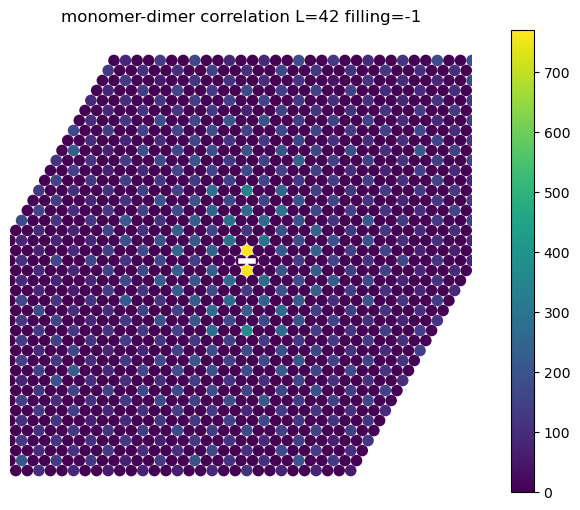

In [126]:
fig, ax = plt.subplots(1, 1, figsize=[10, 6])
ax.axis("off")
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_aspect("equal")
ax.plot([0, 1], [0, 0], color="w", lw=4)

import matplotlib
patches = []
colors = []
N = matplotlib.colors.Normalize(vmin=0, vmax=np.max(vals))
for i in range(-n//2, n//2):
    for j in range(-n//2, n//2):
        patches.append(matplotlib.patches.Circle((i+j/2, j*np.sqrt(3)/2), radius=0.5))
        colors.append(matplotlib.colormaps["viridis"](N(vals[(i+n//2)%n - n//2, (j+n//2)%n-n//2])))

ax.add_collection(matplotlib.collections.PatchCollection(patches, facecolors=colors))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=N, cmap="viridis"), ax=ax)
plt.title("monomer-dimer correlation L=42 filling=-1")

In [3]:
n = 42
vals = np.zeros((n, n))
for l in read_mono_di_line("data/42x42-6-10000000-mono-di.dat", n):
    for g in l:
        vals[g[0], g[1]] += 1

Text(0.5, 1.0, 'monomer-dimer correlation L=42 filling=-2')

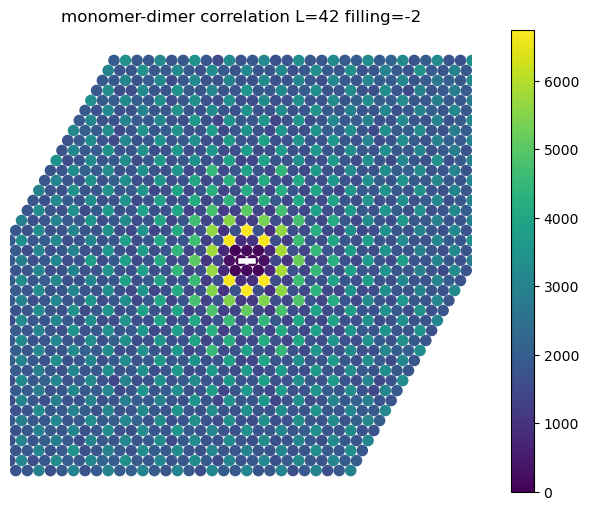

In [4]:
fig, ax = plt.subplots(1, 1, figsize=[10, 6])
ax.axis("off")
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_aspect("equal")
ax.plot([0, 1], [0, 0], color="w", lw=4)

import matplotlib
patches = []
colors = []
N = matplotlib.colors.Normalize(vmin=0, vmax=np.max(vals))
for i in range(-n//2, n//2):
    for j in range(-n//2, n//2):
        patches.append(matplotlib.patches.Circle((i+j/2, j*np.sqrt(3)/2), radius=0.5))
        colors.append(matplotlib.colormaps["viridis"](N(vals[(i+n//2)%n - n//2, (j+n//2)%n-n//2])))

ax.add_collection(matplotlib.collections.PatchCollection(patches, facecolors=colors))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=N, cmap="viridis"), ax=ax)
plt.title("monomer-dimer correlation L=42 filling=-2")

In [118]:
p1, p2, p3 = [], [], []
for l in read_mono_di_line("data/42x42-6-10000000-mono-di.dat", 42):
    v1, v2, v3 = 0, 0, 0
    for g in l:
        g = tuple(g)
        if g == (1, 2):
            v1 += 1
        elif g == (10, 0):
            v2 += 1
        elif g == (10, 10):
            v3 += 1
    p1.append(v1)
    p2.append(v2)
    p3.append(v3)

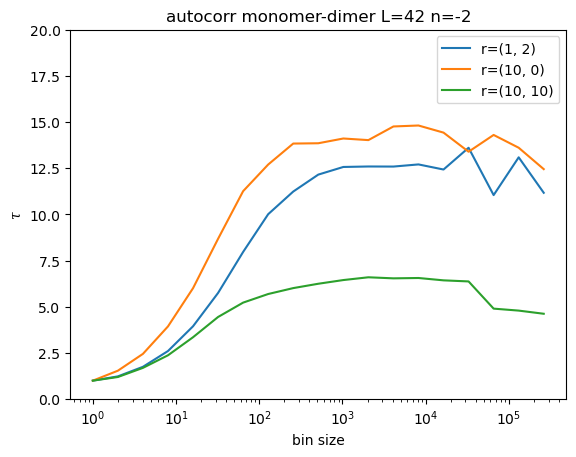

In [7]:
autocorr(p1, "r=(1, 2)")
autocorr(p2, "r=(10, 0)")
autocorr(p3, "r=(10, 10)")
plt.title("autocorr monomer-dimer L=42 n=-2")
plt.xscale("log")
plt.ylim([0, 20])
plt.legend()

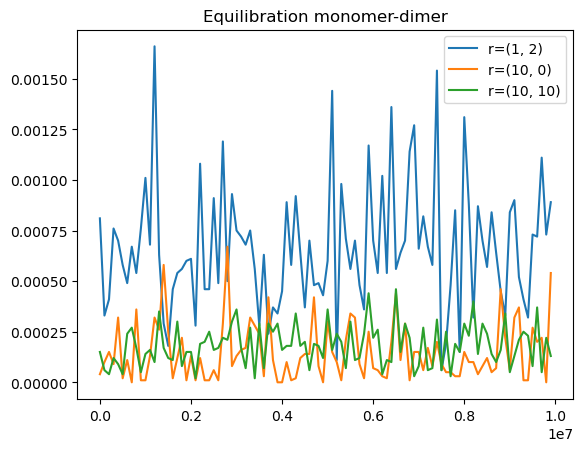

In [120]:
xs = np.arange(len(p1)//100000) * 100000
plt.plot(xs, bin(np.array(p1), 100000), label="r=(1, 2)")
plt.plot(xs, bin(np.array(p2), 100000), label="r=(10, 0)")
plt.plot(xs, bin(np.array(p3), 100000), label="r=(10, 10)")
plt.title("Equilibration monomer-dimer")
plt.legend()

## Tilings

In [7]:
pos = list(read_trimers_line("data/96x96-3-1000000.1000-trimers.dat", 96))
# pos = list(read_trimers_line("data/96x96-3-1000-trimers.dat", 96))

In [8]:
def topo_sectors(pos, lines, l):
    mpos = set(pos)
    vals = []
    for start, dir in lines:
        cpos = start
        total = 0
        while True:
            if cpos in mpos:
                total += 1

            if dir == 0:
                if cpos[2] == 0:
                    cpos = (cpos[0] - 1, cpos[1] + 1, 1)
                else:
                    cpos = (cpos[0], cpos[1] + 1, 0)
            elif dir == 1:
                if cpos[2] == 0:
                    cpos = (cpos[0], cpos[1], 1)
                else:
                    cpos = (cpos[0] + 1, cpos[1] + 1, 0)
            elif dir == 2:
                if cpos[2] == 0:
                    cpos = (cpos[0] + 1, cpos[1] - 1, 1)
                else:
                    cpos = (cpos[0] + 1, cpos[1], 0)

            cpos = (cpos[0] % l, cpos[1] % l, cpos[2])

            if cpos == start:
                break
        vals.append(total)
    return vals

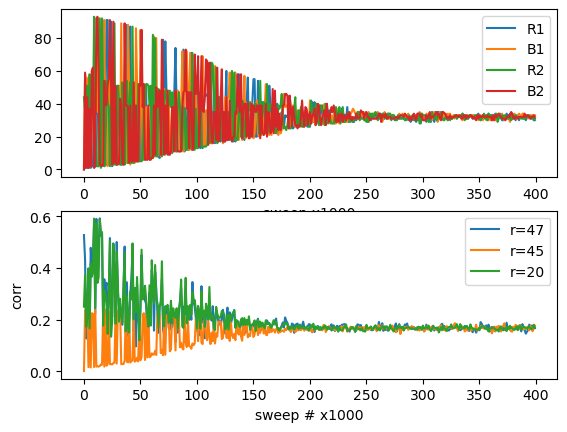

In [ ]:
fig, ax = plt.subplots(2, 1)

x1, x2, x3, x4 = [], [], [], []
for i in range(1000):
    x1.append(topo_sectors(pos[i], [((0, 0, 0), 0)], 96)[0])
    x2.append(topo_sectors(pos[i], [((1, 0, 0), 0)], 96)[0])
    x3.append(topo_sectors(pos[i], [((0, 0, 0), 1)], 96)[0])
    x4.append(topo_sectors(pos[i], [((1, 0, 0), 1)], 96)[0])

ax[0].plot(x1[:400], label="R1")
ax[0].plot(x2[:400], label="B1")
ax[0].plot(x3[:400], label="R2")
ax[0].plot(x4[:400], label="B2")
ax[1].set_ylabel("Quantum numbers")
ax[0].legend()

d1 = read_trimers_r("data/96x96-3-1000000.1000-trimers-cut.dat", 96, 47)
d2 = read_trimers_r("data/96x96-3-1000000.1000-trimers-cut.dat", 96, 45)
d3 = read_trimers_r("data/96x96-3-1000000.1000-trimers-cut.dat", 96, 20)
ax[1].set_ylabel("Trimer-trimer correlation")
ax[1].plot(d1[:400], label="r=47")
ax[1].plot(d2[:400], label="r=45")
ax[1].plot(d3[:400], label="r=20")
ax[1].set_xlabel("Time (x1000)")
ax[1].legend()

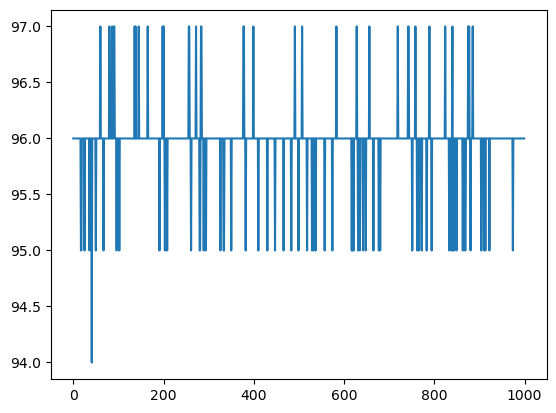

In [16]:
plt.plot([topo_sectors(pos[i], [((0, 0, 0), 0)], 96)[0]
          + topo_sectors(pos[i], [((1, 0, 0), 0)], 96)[0]
          + topo_sectors(pos[i], [((2, 0, 0), 0)], 96)[0] for i in range(1000)])

## Trimer-Trimer correlation

In [33]:
# x = read_trimers_cut("data/72x72-6-1000000-trimers-cut.dat", 72, stride=1, skip=500000)
x1 = read_trimers_cut("data/96x96-3-2000000-trimers-cut.dat", 96, stride=1, skip=800000)
# x2 = read_trimers_cut("data/108x108-3-5000000-trimers-cut.dat", 108, skip=2500000, stride=10)

0.020880094545383004
0.02090502758742909
-0.020904997669836042
0.020914637041567992


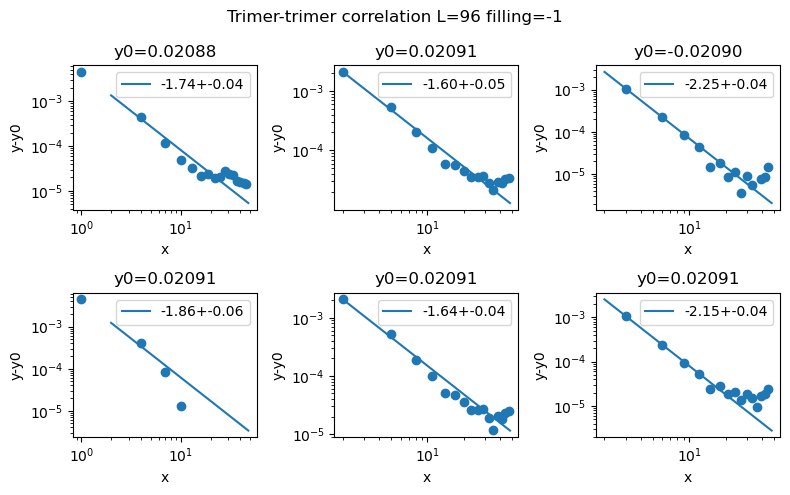

In [42]:
fig, ax = plt.subplots(2, 3, figsize=[8, 5])

xr = x1 / x1.sum()
xs = np.arange(x1.shape[0])

import scipy

def fit(x, A, B, C):
    return B * np.power(x, A) + C

def fitplot(x, y, ax):
    P, cov = scipy.optimize.curve_fit(fit, x, y, p0=[-2, 1, 0.1])
    y0 = P[2]
    print(y0)
    ax.plot(np.linspace(2, xr.shape[0], 100), fit(np.linspace(2, xr.shape[0], 100), *P)-y0, label=f"{P[0]:.2f}+-{np.sqrt(cov[0, 0]):.2f}")
    ax.scatter(x, y-y0)
    ax.legend()

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("y-y0")
    ax.set_xlabel("x")
    ax.set_title(f"y0={y0:.5f}")

fitplot(xs[1::3], xr[1::3], ax[0, 0])
fitplot(xs[2::3], xr[2::3], ax[0, 1])
fitplot(xs[3::3], -xr[3::3], ax[0, 2])

def fit(x, A, B):
    return B * np.power(x, A)

p0 = (xr[-10:].max() + xr[-10:].min())/2


def fitplot(x, y, ax):
    P, cov = scipy.optimize.curve_fit(fit, x, y, p0=[-2, 1])
    ax.plot(np.linspace(2, xr.shape[0], 100), fit(np.linspace(2, xr.shape[0], 100), *P), label=f"{P[0]:.2f}+-{np.sqrt(cov[0, 0]):.2f}")
    ax.scatter(x, y)
    ax.legend()

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("y-y0")
    ax.set_xlabel("x")
    ax.set_title(f"y0={p0:.5f}")

print(p0)
fitplot(xs[1::3], xr[1::3]-p0, ax[1, 0])
fitplot(xs[2::3], xr[2::3]-p0, ax[1, 1])
fitplot(xs[3::3], -xr[3::3]+p0, ax[1, 2])

plt.suptitle("Trimer-trimer correlation L=96 filling=-1")
plt.tight_layout()

In [58]:
d1 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 2, skip=0, stride=1)
d2 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 20, skip=0, stride=1)
d3 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 50, skip=0, stride=1)

Text(0.5, 1.0, 'autocorr trimer-trimer L=108 n=-1 skip=1M')

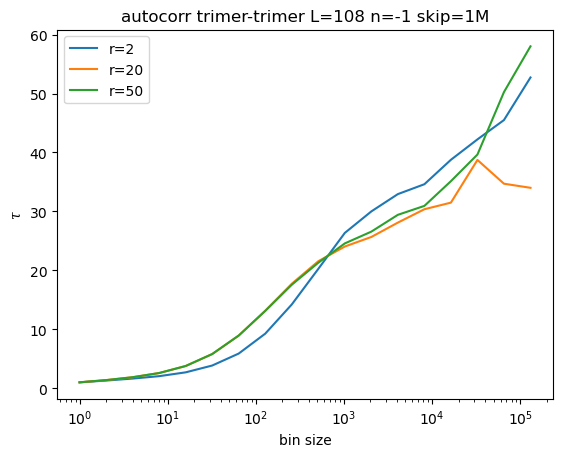

In [65]:
skip = 1000000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=20")
autocorr(d3[skip:], "r=50")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=108 n=-1 skip=1M")

In [68]:
d1 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 2, skip=0, stride=1)
d2 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 10, skip=0, stride=1)
d3 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 25, skip=0, stride=1)

Text(0.5, 1.0, 'autocorr trimer-trimer L=60 n=-1 skip=1M')

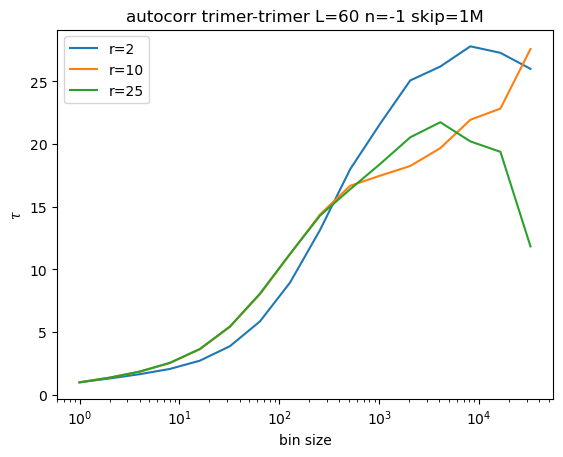

In [69]:
skip = 1000000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=10")
autocorr(d3[skip:], "r=25")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=60 n=-1 skip=1M")

In [73]:
d1 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 2, skip=0, stride=1)
d2 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 10, skip=0, stride=1)
d3 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 25, skip=0, stride=1)

Text(0.5, 1.0, 'autocorr trimer-trimer L=60 n=-2 skip=0.5M')

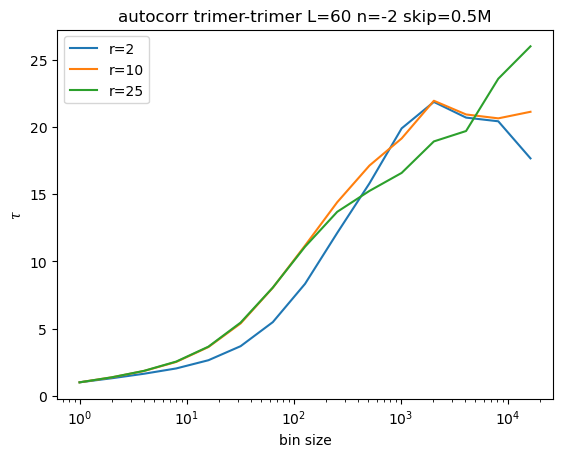

In [74]:
skip = 500000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=10")
autocorr(d3[skip:], "r=25")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=60 n=-2 skip=0.5M")

## Monomer-Monomer

### Correlation

$$\overline{x}=\sin(\pi x/L)/(\pi/L)$$

/tmp/ipykernel_1224638/928752915.py:14: RuntimeWarning: divide by zero encountered in power
  return B * np.power(np.abs(x), A)


Text(0.5, 0, 'r (transformed)')

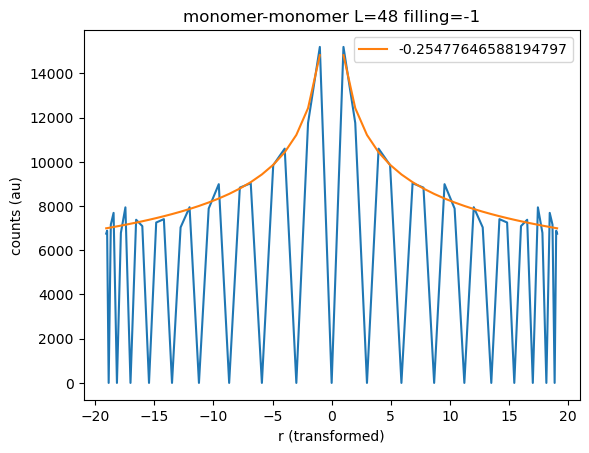

In [21]:
i = 60
L = i
d = read_monomers_cut(f"data/{i}x{i}-3-3000000-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

crit = np.logical_and(dn>0, dk>0)
P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])

plt.plot(dk, dn)
plt.plot(dk, fit(dk, *P), label=str(P[0]))

plt.legend()
plt.title("monomer-monomer L=48 filling=-1")
plt.ylabel("counts (au)")
plt.xlabel("r (transformed)")

Text(0.5, 0, '$\\overline{x}$')

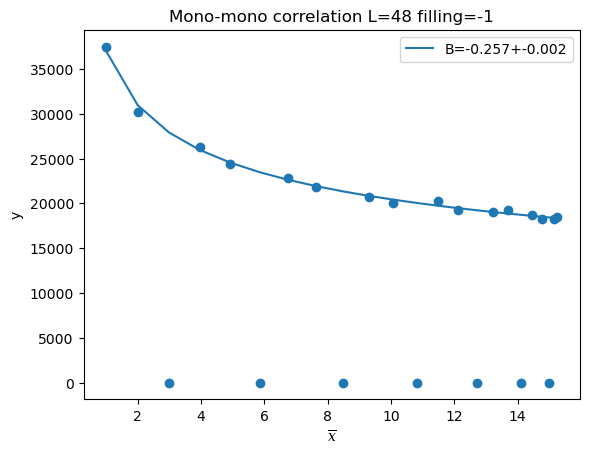

In [31]:
i = 48
L = i
d = read_monomers_cut(f"data/{i}x{i}-3-50000000.10-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

sigma = np.sqrt(dn/5e6*(1-dn/5e6)*5e6)

crit = np.logical_and(dn>0, dk>0)
P, cov = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10], sigma=sigma[crit], absolute_sigma=True)

plt.scatter(dk[L//2:], dn[L//2:])
plt.plot(dk[L//2:], fit(dk[L//2:], *P), label=f"B={P[0]:.3f}+-{np.sqrt(cov[0,0]):.3f}")

plt.legend()
plt.title(f"Mono-mono correlation L={L} filling=-1")
plt.ylabel("y")
plt.xlabel("$\\overline{x}$")

/tmp/ipykernel_3071769/1375468683.py:14: RuntimeWarning: divide by zero encountered in power
  return B * np.power(np.abs(x), A)


Text(0.5, 1.0, 'monomer-monomer L=48 filling=-2')

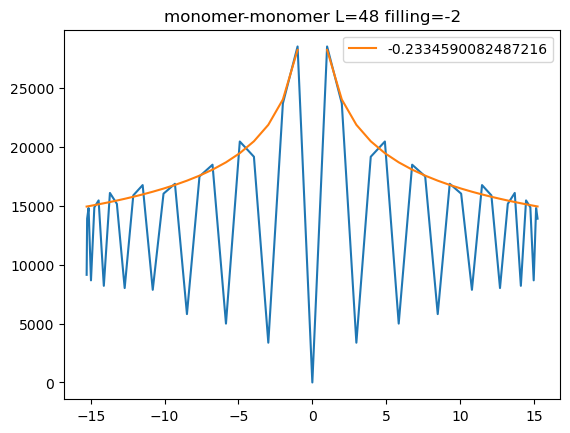

In [65]:
i = 48
L = i
d = read_monomers_cut(f"data/{i}x{i}-6-1000000-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

crit = np.logical_and(dn>12000, dk>0)
P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])

plt.plot(dk, dn)
plt.plot(dk, fit(dk, *P), label=str(P[0]))
plt.legend()
plt.title("monomer-monomer L=48 filling=-2")

In [7]:
p1 = read_monomers_r(f"data/96x96-3-50000000-monomers.dat", 96, [(0, 1), (0, 10), (0, 25), (31, 30)])

Text(0.5, 1.0, 'autocorr mono-mono L=60 n=-1 skip=0.5M')

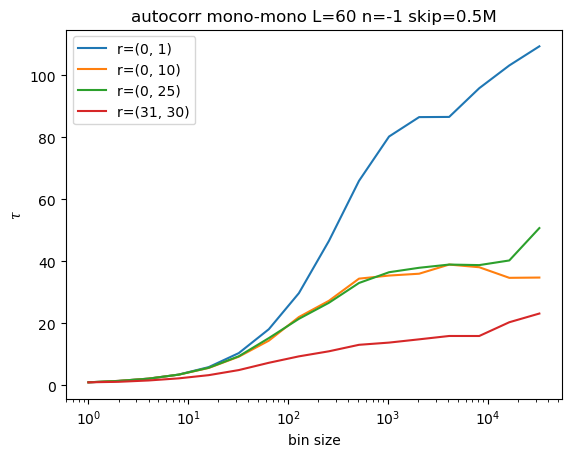

In [8]:
skip = 500000
autocorr(p1[(0, 1)][skip:], "r=(0, 1)")
autocorr(p1[(0, 10)][skip:], "r=(0, 10)")
autocorr(p1[(0, 25)][skip:], "r=(0, 25)")
autocorr(p1[(31, 30)][skip:], "r=(31, 30)")
plt.legend()
plt.xscale("log")
plt.title("autocorr mono-mono L=60 n=-1 skip=0.5M")

Text(0.5, 1.0, 'equilib mono-mono L=60 n=-1')

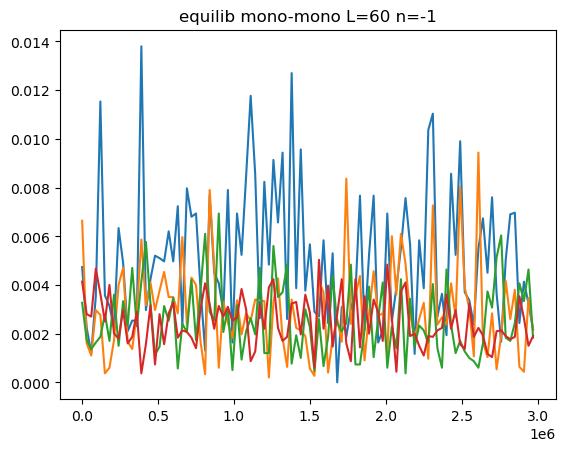

In [110]:
n = 30000
rng = np.arange(len(p1[(0, 1)])//n) * n
plt.plot(rng, bin(p1[(0, 1)], n))
plt.plot(rng, bin(p1[(0, 10)], n))
plt.plot(rng, bin(p1[(0, 25)], n))
plt.plot(rng, bin(p1[(24, 25)], n))
plt.title("equilib mono-mono L=60 n=-1")

### 2D correlation

In [131]:
d1 = read_monomers(f"data/0K/6x6-3-50000000.10-monomers.dat", 6)
d2 = read_monomers(f"data/0K/12x12-3-50000000.10-monomers.dat", 12)
d3 = read_monomers(f"data/0K/24x24-3-50000000.10-monomers.dat", 24)
d4 = read_monomers(f"data/0K/48x48-3-50000000.10-monomers.dat", 48)
d5 = read_monomers(f"data/0K/96x96-3-50000000.10-monomers.dat", 96)

<Figure size 640x480 with 0 Axes>

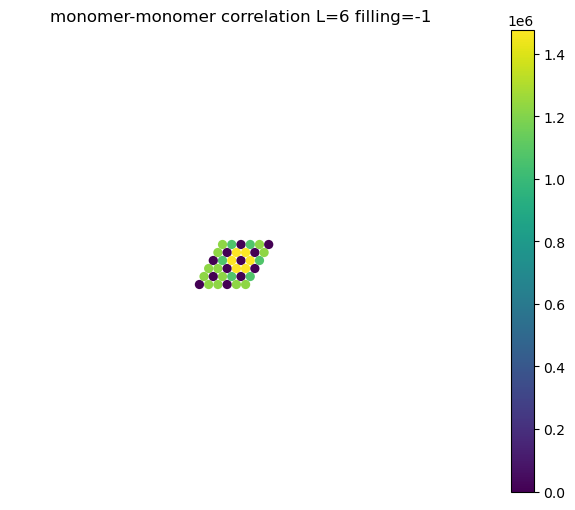

<Figure size 640x480 with 0 Axes>

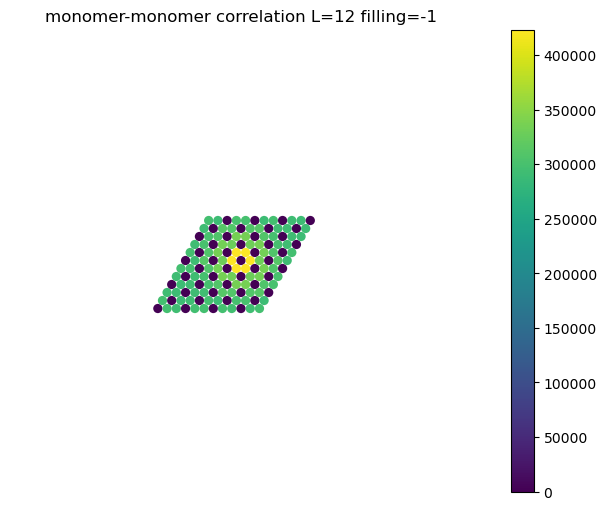

<Figure size 640x480 with 0 Axes>

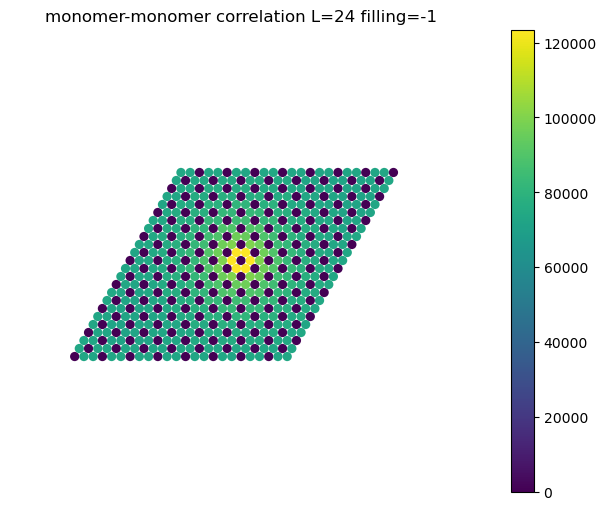

<Figure size 640x480 with 0 Axes>

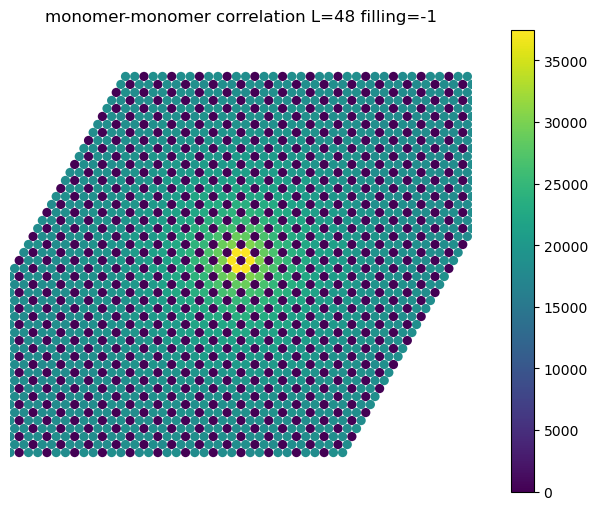

<Figure size 640x480 with 0 Axes>

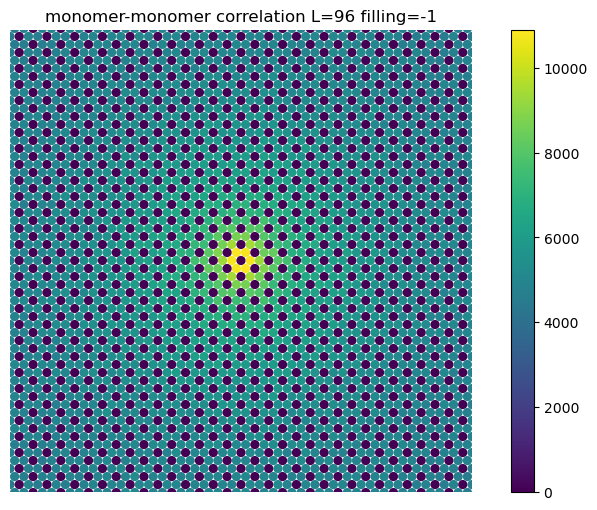

In [132]:
plt.figure()
plot2d(d1, 6)
plt.figure()
plot2d(d2, 12)
plt.figure()
plot2d(d3, 24)
plt.figure()
plot2d(d4, 48)
plt.figure()
plot2d(d5, 96)

# T>0

In [4]:
pos = list(read_trimers_line("data/idealbw/60x60_r-3_uinf_4j0.00_1000.1_0/positions.dat", 60))
pocket.width = 60
pocket.height = 60

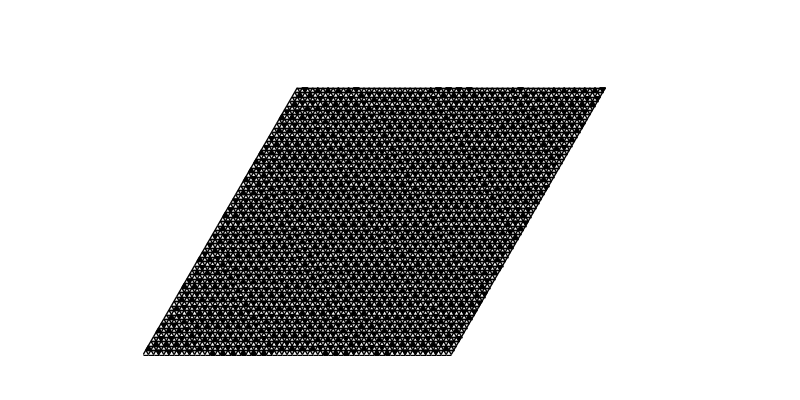

In [5]:
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
pocket.draw_hexalattice(ax)
pocket.show_tiling(ax, (list(pos)[10], None), wf="tri", color="black", zoom=1)

In [370]:
pos = list(read_trimers_line("data/FT/48x48_r-3_uinf_4j-15.00_10000.5_0/positions.dat", 48))
pocket.width = 48
pocket.height = 48

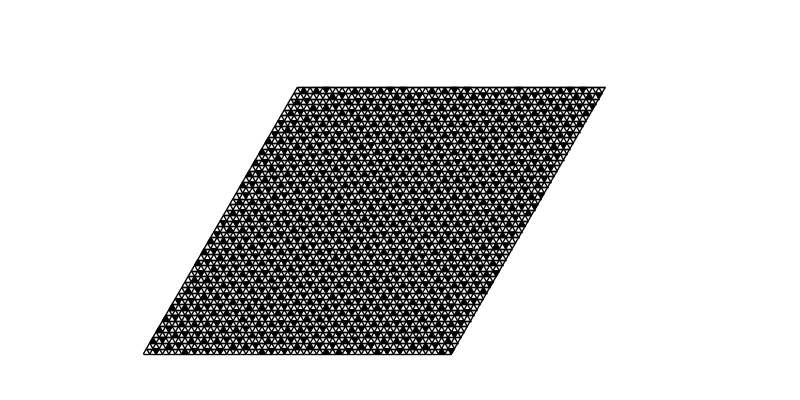

In [371]:
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
pocket.draw_hexalattice(ax)
pocket.show_tiling(ax, (list(pos)[999], None), wf="tri", color="black", zoom=1)

In [348]:
data1 = read_accumulator("data/FT/48x48_r-3_uinf_4j0.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))
data2 = read_accumulator("data/FT/48x48_r-3_uinf_4j-1.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))
data3 = read_accumulator("data/FT/48x48_r-3_uinf_4j-2.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))
data4 = read_accumulator("data/FT/48x48_r-3_uinf_4j-3.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))
data5 = read_accumulator("data/FT/48x48_r-3_uinf_4j-4.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))

Text(0.5, 1.0, '-4')

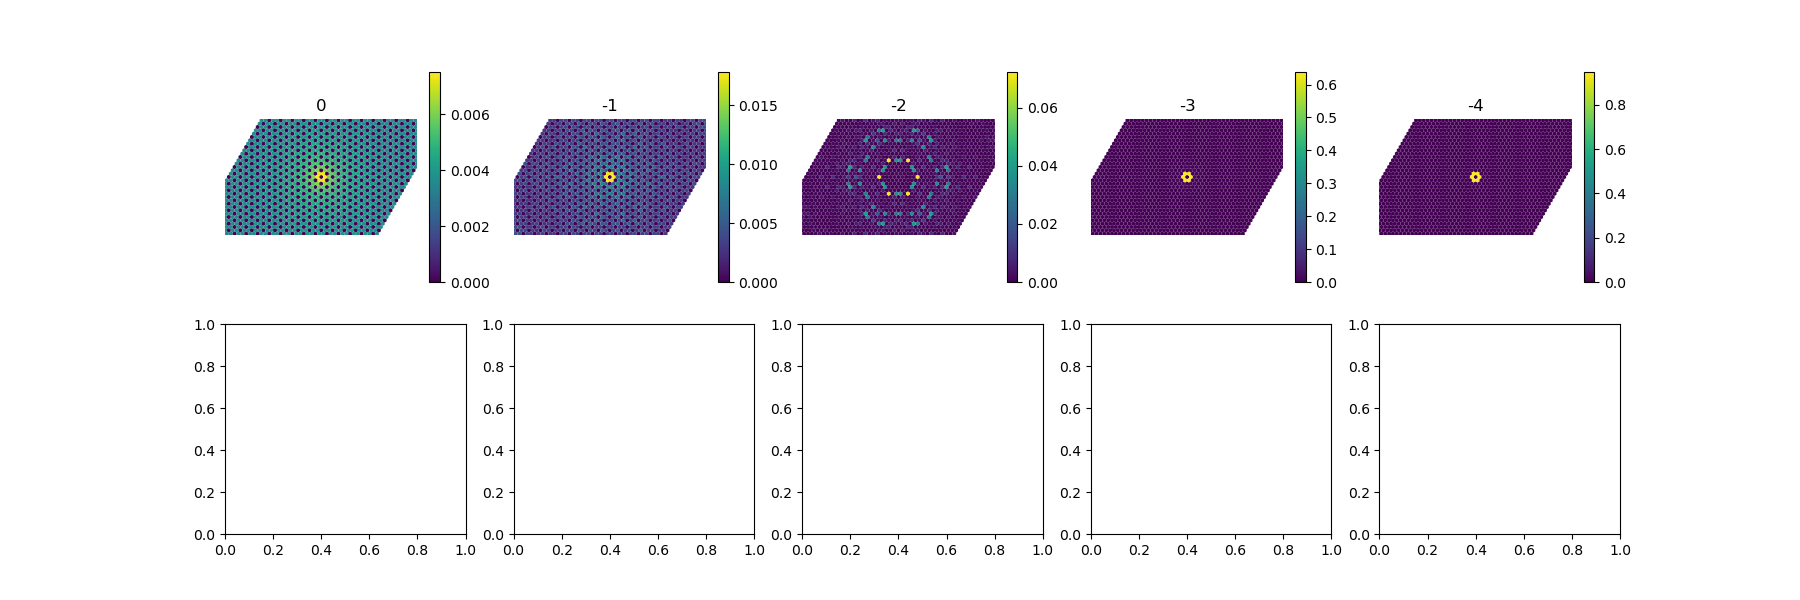

In [266]:
fig, ax = plt.subplots(2, 5, figsize=[18, 6])
plot2d(ax[0,0], data1)
plot2d(ax[0,1], data2)
plot2d(ax[0,2], data3)
plot2d(ax[0,3], data4)
plot2d(ax[0,4], data5)
ax[0,0].set_title("0")
ax[0,1].set_title("-1")
ax[0,2].set_title("-2")
ax[0,3].set_title("-3")
ax[0,4].set_title("-4")

In [284]:
data1 = read_accumulator("data/FT/48x48_r-3_uinf_4j0.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))
data2 = read_accumulator("data/FT/48x48_r-3_uinf_4j1.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))
data3 = read_accumulator("data/FT/48x48_r-3_uinf_4j2.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))
data4 = read_accumulator("data/FT/48x48_r-3_uinf_4j3.00_10000000.5_0/mono-mono.dat", skip=20)[0].reshape((48, 48))

Text(0.5, 1.0, '3')

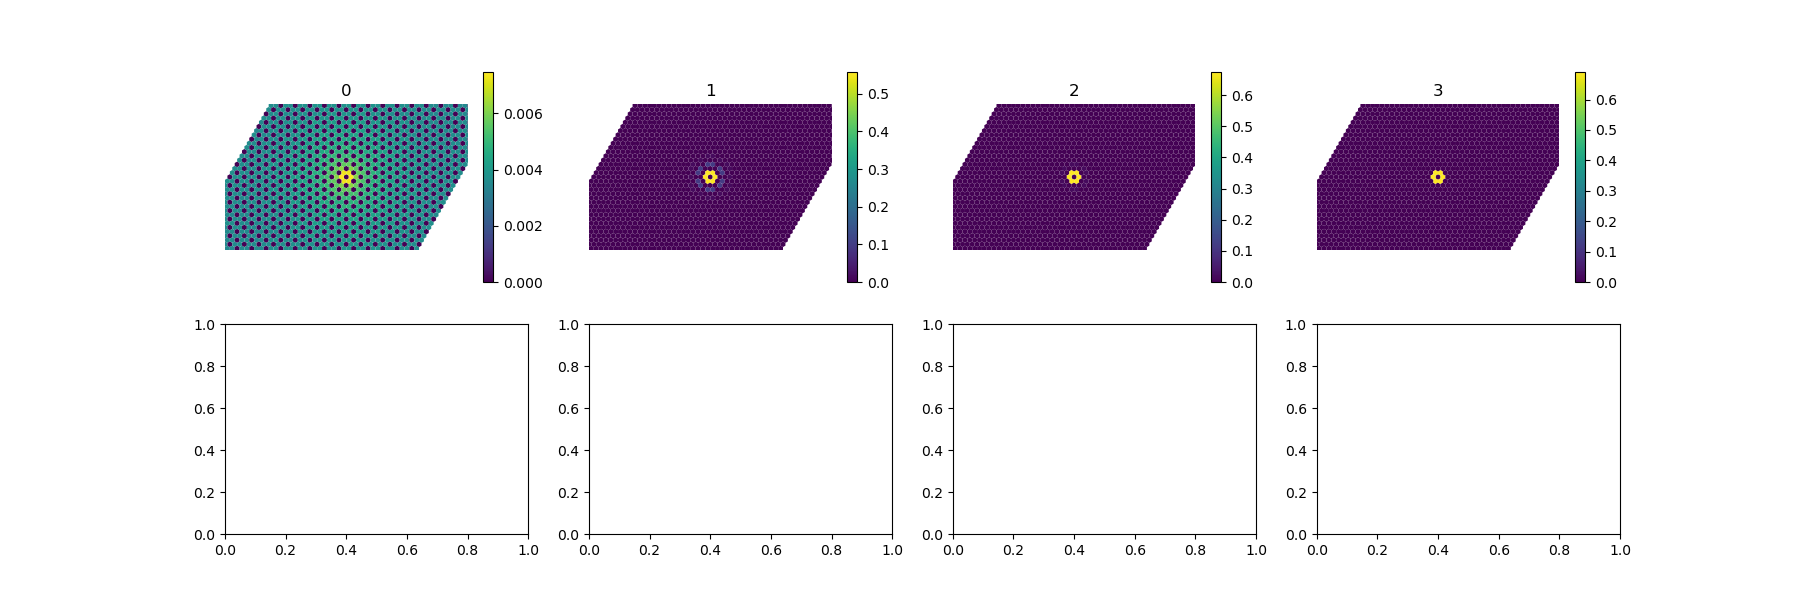

In [287]:
fig, ax = plt.subplots(2, 4, figsize=[18, 6])
plot2d(ax[0,0], np.log(data1+1))
plot2d(ax[0,1], np.log(data2+1))
plot2d(ax[0,2], np.log(data3+1))
plot2d(ax[0,3], np.log(data4+1))
ax[0,0].set_title("0")
ax[0,1].set_title("1")
ax[0,2].set_title("2")
ax[0,3].set_title("3")

scratch

In [39]:
# data1 = read_accumulator("data/FT/48x48_bw/tri-tri.dat")[0].reshape((60, 60, 2))
data1 = read_accumulator("data/idealbw/60x60_r-3_uinf_4j0.00_1000.1_0/tri-tri.dat")[0].reshape((60, 60, 2))

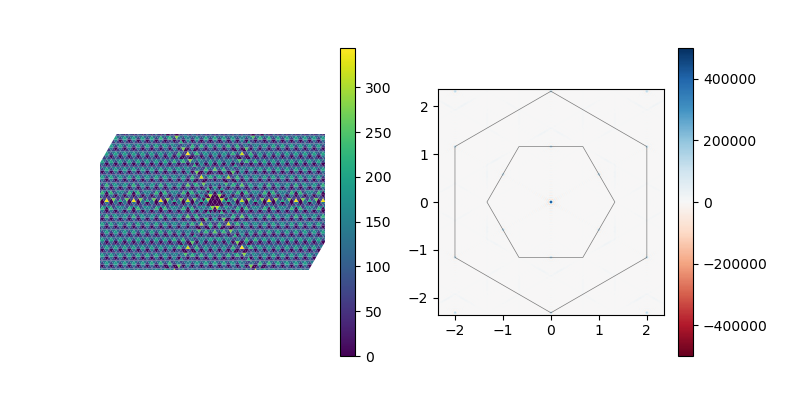

In [40]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot2d_hex(ax[0], data1)
plot_FT(ax[1], FT_hex2(data1), proj="re")

In [48]:
data1 = read_accumulator("data/largejbw/48x48_r-3_uinf_4j-2.50_100000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data2 = read_accumulator("data/largejbw/48x48_r-3_uinf_4j-4.00_100000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data3 = read_accumulator("data/largejbw/48x48_r-3_uinf_4j-10.00_100000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data4 = read_accumulator("data/largejbw/48x48_r-3_uinf_4j-15.00_100000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))

Text(0.5, 1.0, 'j=-15')

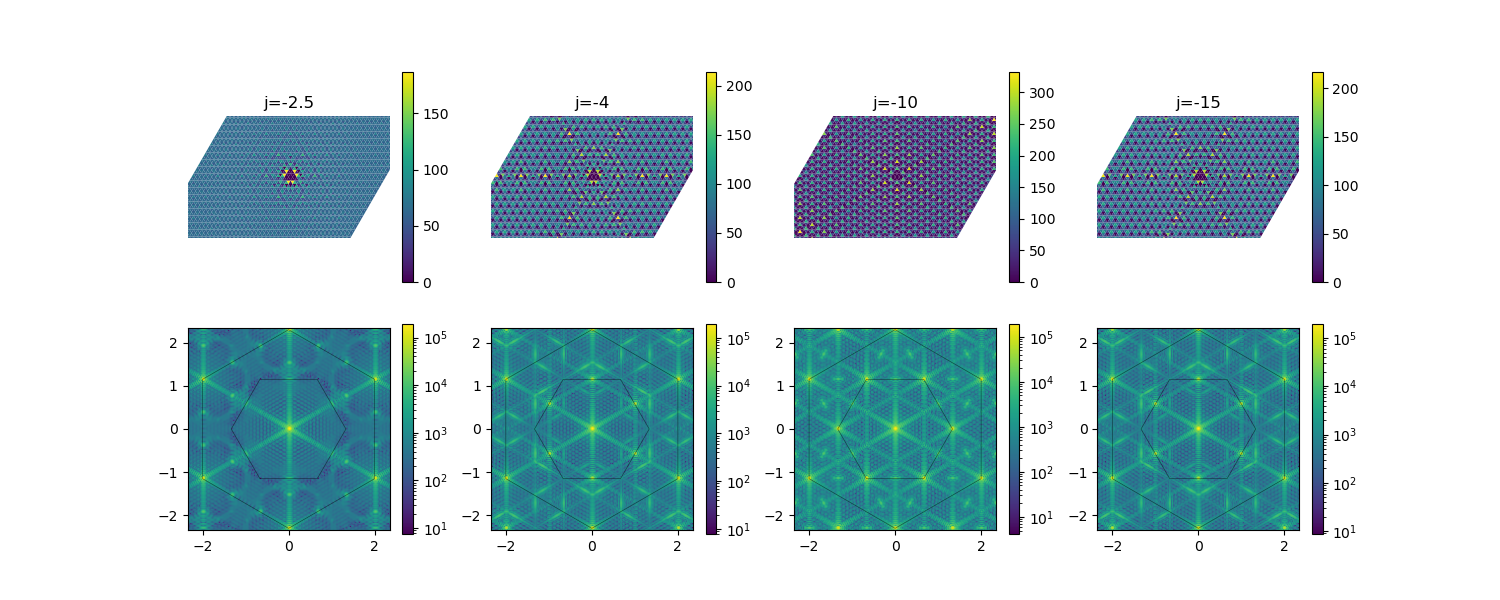

In [49]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[0,3], data4)
plot_FT(ax[1,0], FT_hex2(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex2(data2), proj="logabs")
plot_FT(ax[1,2], FT_hex2(data3), proj="logabs")
plot_FT(ax[1,3], FT_hex2(data4), proj="logabs")
ax[0,0].set_title("j=-2.5")
ax[0,1].set_title("j=-4")
ax[0,2].set_title("j=-10")
ax[0,3].set_title("j=-15")

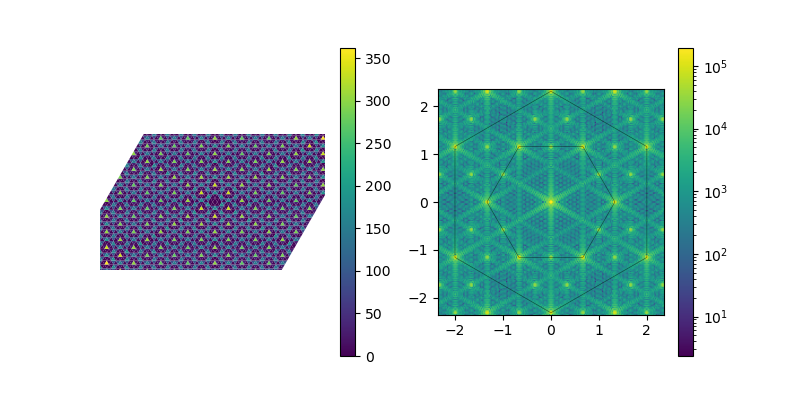

In [52]:
data = read_accumulator("data/largejbw/48x48_r-3_uinf_4j-10.00_100000.5_1/tri-tri.dat", skip=0)[0].reshape((48, 48, 2))
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot2d_hex(ax[0], data)
plot_FT(ax[1], FT_hex2(data), proj="logabs")

In [87]:
data1 = read_accumulator("data/bwtrans/48x48_r-3_uinf_4j-0.50_40000000.5_0/tri-tri.dat", skip=2000)[0].reshape((48, 48, 2))
data2 = read_accumulator("data/bwtrans/48x48_r-3_uinf_4j-3.50_40000000.5_0/tri-tri.dat", skip=2000)[0].reshape((48, 48, 2))

Text(0.5, 1.0, 'rt3')

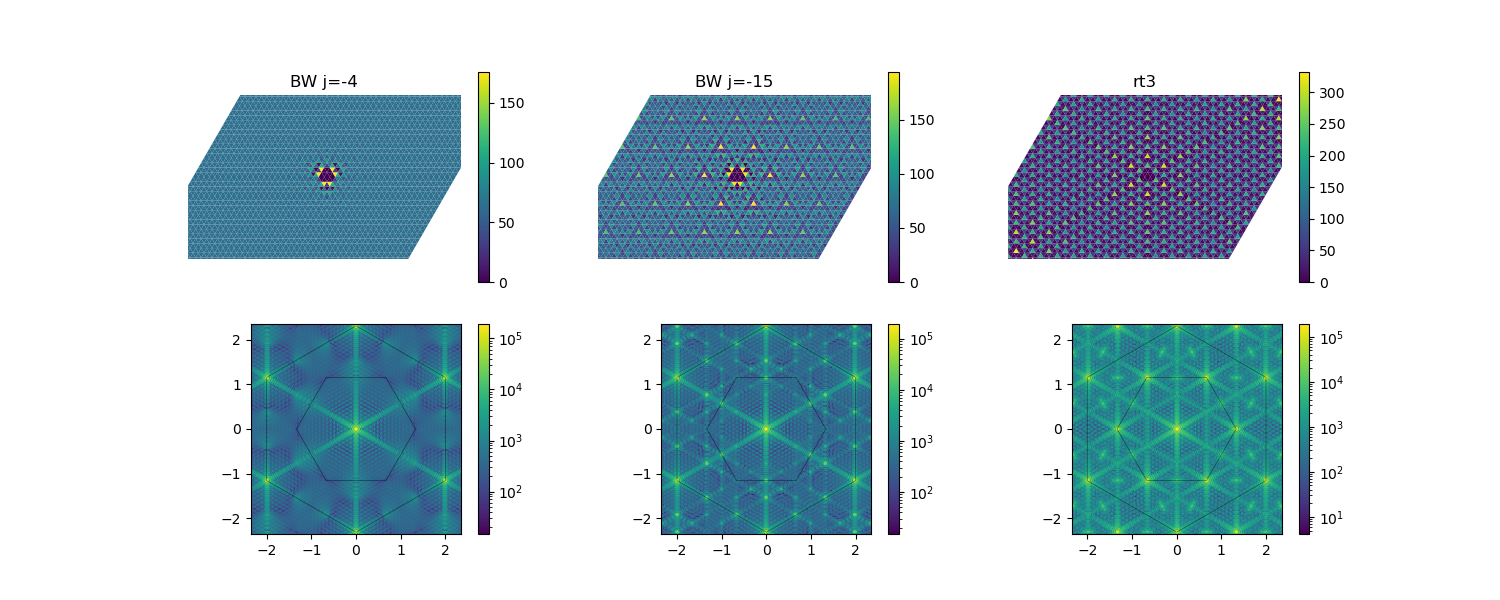

In [88]:
fig, ax = plt.subplots(2, 3, figsize=[15, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot_FT(ax[1,0], FT_hex2(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex2(data2), proj="logabs")
plot_FT(ax[1,2], FT_hex2(data3), proj="logabs")
ax[0,0].set_title("BW j=-4")
ax[0,1].set_title("BW j=-15")
ax[0,2].set_title("rt3")

608.9621926475339
38.67212341204588


Text(0.5, 1.0, 'rt3')

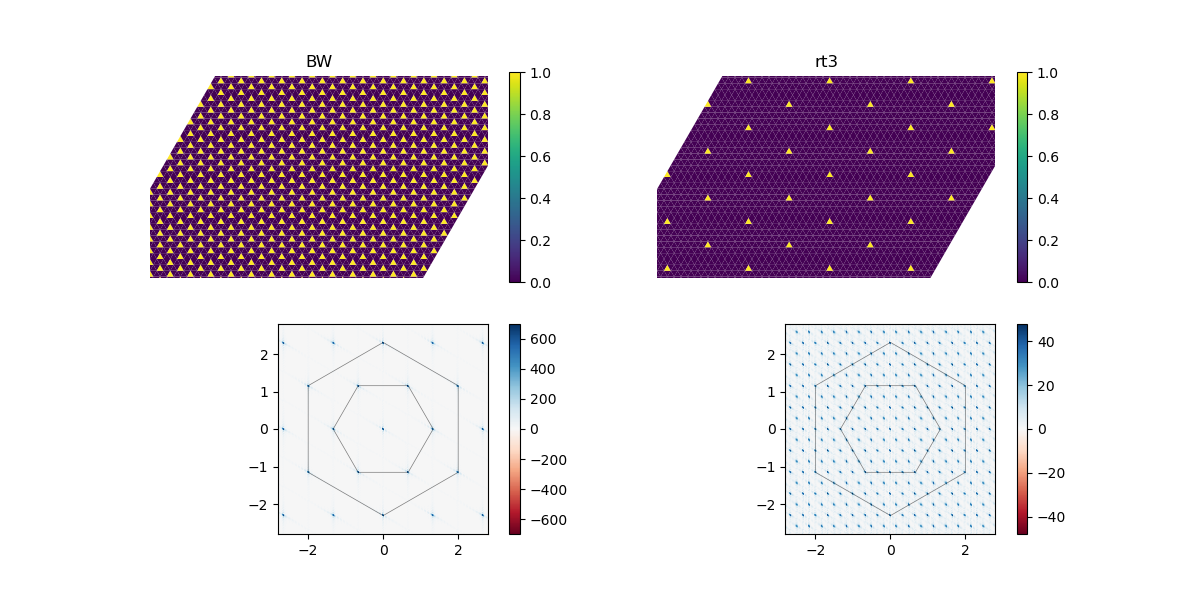

In [95]:
data3 = np.zeros_like(data1)
for i in range(data3.shape[1]):
    data3[(i%3)::3, i, 0] = 1
data4 = np.zeros_like(data3)
for i in range(0, data4.shape[1], 4):
    data4[(i%3)*4::12, i, 0] = 1

fig, ax = plt.subplots(2, 2, figsize=[12, 6])
plot2d_hex(ax[0,0], data3)
plot2d_hex(ax[0,1], data4)
plot_FT(ax[1,0], FT_hex(data3))
plot_FT(ax[1,1], FT_hex(data4))
ax[0,0].set_title("BW")
ax[0,1].set_title("rt3")

In [421]:
data = read_accumulator("data/FT/36x36_r-3_uinf_4j1.00_10000000.5_0/mono-mono.dat")[0].reshape((36, 36))

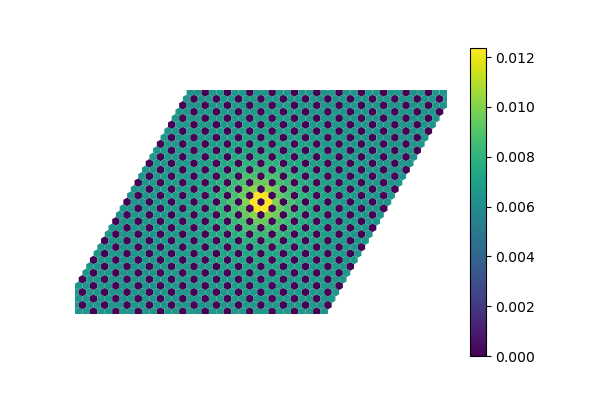

In [63]:
plot2d(data)

In [442]:
data1 = read_accumulator("data/FT/12x12_r-3_uinf_4j0.00_10000000.5_0/tri-tri.dat", skip=5)[0].reshape((12, 12, 2))
data2 = read_accumulator("data/FT/12x12_r-3_u2.00_4j0.00_10000000.5_0/tri-tri.dat", skip=5)[0].reshape((12, 12, 2))
data3 = read_accumulator("data/FT/12x12_r-3_u1.00_4j0.00_10000000.5_0/tri-tri.dat", skip=5)[0].reshape((12, 12, 2))
data4 = read_accumulator("data/FT/12x12_r-3_u0.50_4j0.00_10000000.5_0/tri-tri.dat", skip=5)[0].reshape((12, 12, 2))
data5 = read_accumulator("data/FT/12x12_r-3_u0.20_4j0.00_10000000.5_0/tri-tri.dat", skip=5)[0].reshape((12, 12, 2))

Text(0.5, 1.0, 'u=0.2')

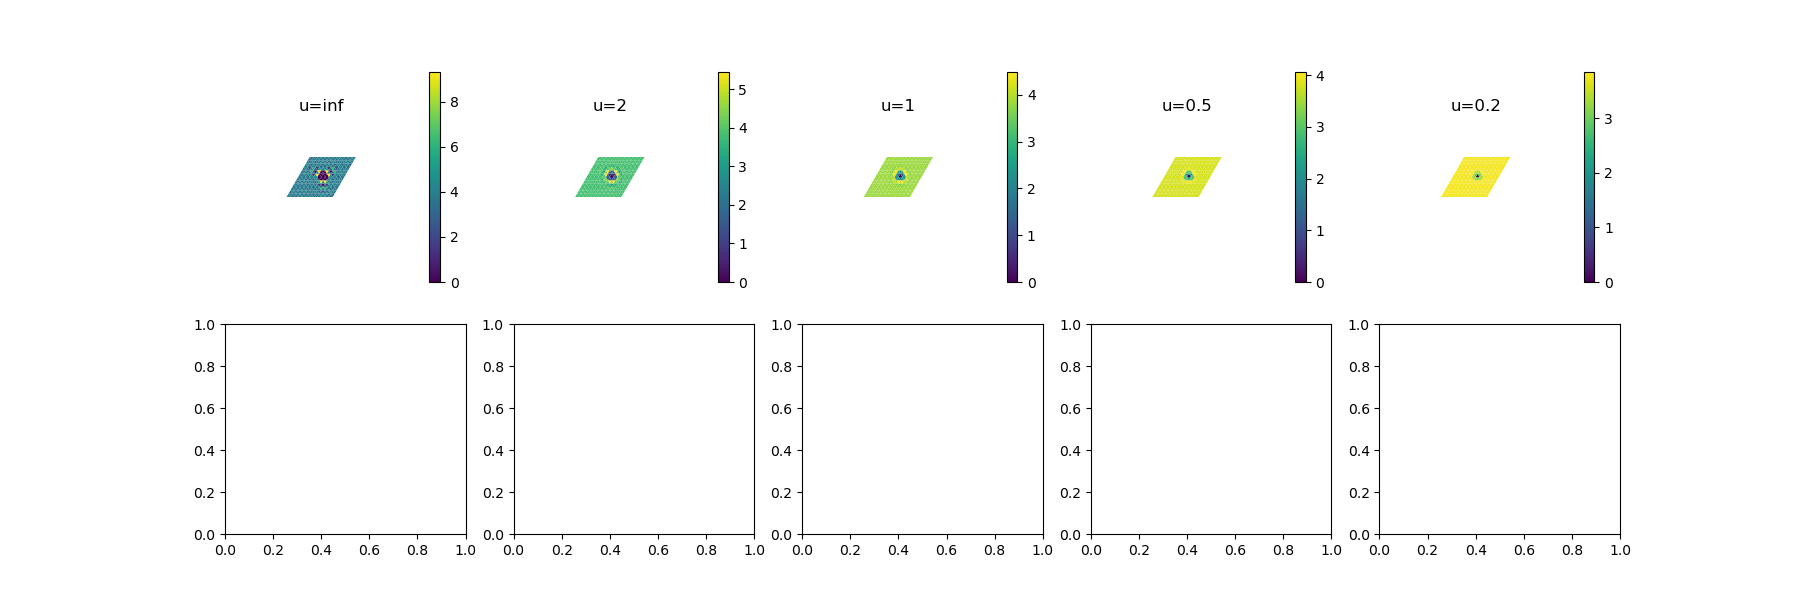

In [443]:
fig, ax = plt.subplots(2, 5, figsize=[18, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[0,3], data4)
plot2d_hex(ax[0,4], data5)
# plot_FT(ax[1,0], FT_hex(data1))
# plot_FT(ax[1,1], FT_hex(data2))
ax[0,0].set_title("u=inf")
ax[0,1].set_title("u=2")
ax[0,2].set_title("u=1")
ax[0,3].set_title("u=0.5")
ax[0,4].set_title("u=0.2")

## Cv transitions

In [177]:
js1 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5])
ds1 = np.array([read_accumulator(f"data/bwtrans/24x24_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js1])
js2 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5, -4, -5, -6, -7])
ds2 = np.array([read_accumulator(f"data/bwtrans/36x36_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=3)[1][1] for x in js2])
js3 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5, -4, -5, -6, -7, -8, -10, -12, -15])
ds3 = np.array([read_accumulator(f"data/bwtrans/48x48_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=3)[1][1] for x in js3])
js4 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5, -4, -5, -6, -7])
ds4 = np.array([read_accumulator(f"data/bwtrans/60x60_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=3)[1][1] for x in js4])

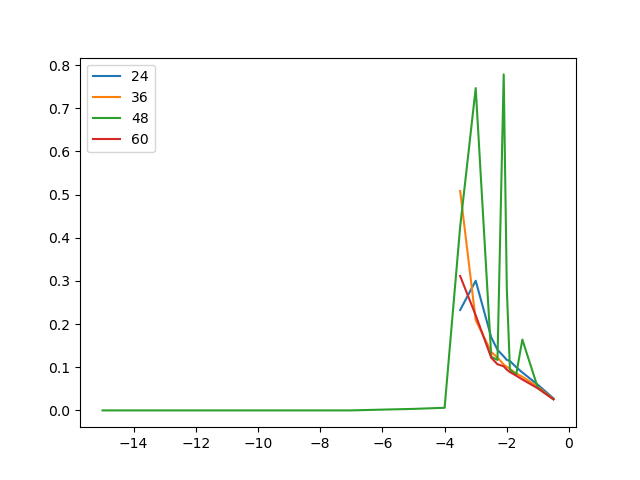

In [178]:
plt.figure()
plt.plot(js1, ds1*ds1*js1*js1/24/24*3, label="24")
plt.plot(js2, ds2*ds2*js2*js2/36/36*3, label="36")
plt.plot(js3, ds3*ds3*js3*js3/48/48*3, label="48")
plt.plot(js4, ds4*ds4*js4*js4/60/60*3, label="60")
plt.legend()

In [184]:
data1 = read_accumulator("data/rt3trans/48x48_r-3_uinf_4j0.09_20000000.5_0/tri-tri.dat", skip=0)[0].reshape((48, 48, 2))
data2 = read_accumulator("data/rt3trans/48x48_r-3_uinf_4j0.11_20000000.5_0/tri-tri.dat", skip=0)[0].reshape((48, 48, 2))

ValueError: data/rt3trans/48x48_r-3_uinf_4j0.09_20000000.5_0/tri-tri.dat

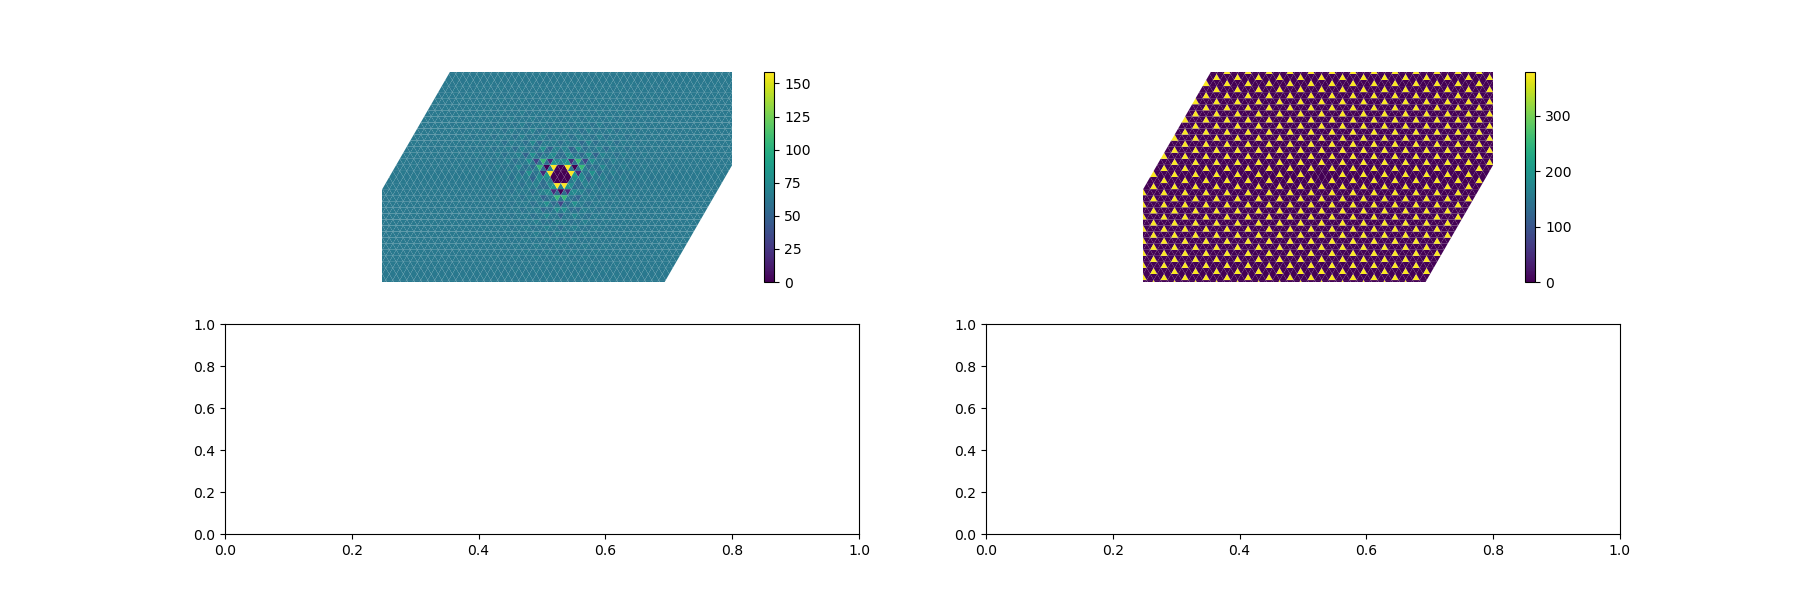

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[18, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)

In [182]:
js = np.array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.4, 0.5])
ds1 = np.array([read_accumulator(f"data/rt3trans/24x24_r-3_uinf_4j{x:.2f}_20000000.5_0/energy.dat", skip=10)[1][1] for x in js])
ds2 = np.array([read_accumulator(f"data/rt3trans/36x36_r-3_uinf_4j{x:.2f}_20000000.5_0/energy.dat", skip=10)[1][1] for x in js])
ds3 = np.array([read_accumulator(f"data/rt3trans/48x48_r-3_uinf_4j{x:.2f}_20000000.5_0/energy.dat", skip=10)[1][1] for x in js])

Text(0, 0.5, 'Cv/N')

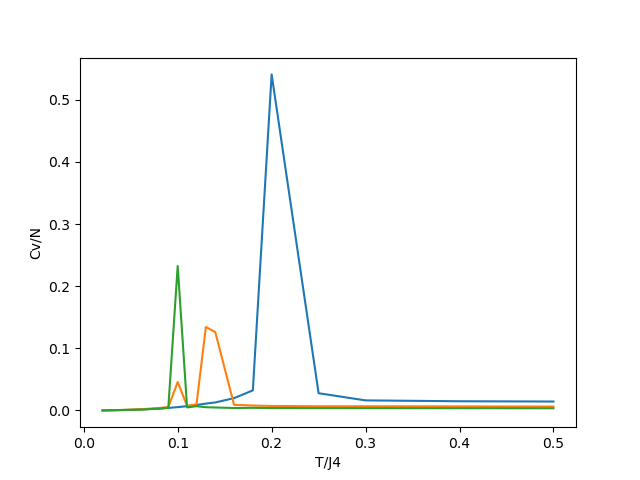

In [183]:
plt.figure()
plt.plot(js, ds1*ds1*js*js/24/24*3)
plt.plot(js, ds2*ds3*js*js/36/36*3)
plt.plot(js, ds3*ds3*js*js/48/48*3)
plt.xlabel("T/J4")
plt.ylabel("Cv/N")

In [164]:
js = np.array([0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 10])
ds0 = np.array([read_accumulator(f"data/FT/6x6_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds1 = np.array([read_accumulator(f"data/FT/12x12_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds2 = np.array([read_accumulator(f"data/FT/24x24_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds3 = np.array([read_accumulator(f"data/FT/36x36_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds4 = np.array([read_accumulator(f"data/FT/48x48_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])

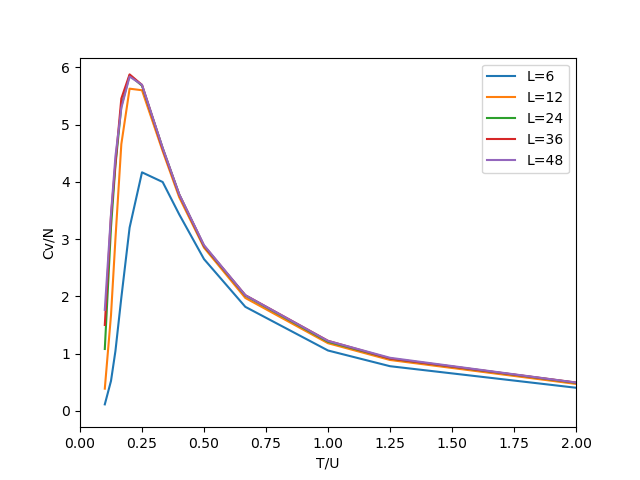

In [30]:
plt.close("all")
plt.figure()
plt.plot(1/js, ds0*ds0*js*js/6/6*3, label="L=6")
plt.plot(1/js, ds1*ds1*js*js/12/12*3, label="L=12")
plt.plot(1/js, ds2*ds2*js*js/24/24*3, label="L=24")
plt.plot(1/js, ds3*ds3*js*js/36/36*3, label="L=36")
plt.plot(1/js, ds4*ds4*js*js/48/48*3, label="L=48")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt.xlim([0, 2])
plt.legend()